# Binary Classification 

Hi, and welcome to your first lab. Here you will build your first Neural Network to detect breast cancer based on numerical features. 

**Requirements**
- This lab assumes that you are familiar with the basic operations in NumPy and PyTorch. 

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- Build a structured learning algorithm, which includes:
    - Data normalization
    - Writing functions for evaluating model performance
    - Training and testing a neural network

# 1 - Import packages and set up the environment
First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](https://matplotlib.org/) is the most popular python package for visualizations
- [sklearn](https://scikit-learn.org/stable/) is a useful package for data science and data analysis
- [torch](https://pytorch.org/) that's what we are trying to learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim

%matplotlib inline

## Config

In Deep Learning, you will often have to deal with a decent amount of constants and numerical values that specify how you preprocess your data, define your model architecture, and set up hyperparameters for your training loop. Therefore, to track all of those numbers, we create a separate class Config, which will have all of these values easily accessible for a later tuning of your model. 

**Important:** To pass our validations, don't change the Config class! However, after you submit your lab, we encourage you to change the values and see how it affects the model performance!

In [2]:
# VALIDATION_FIELD[cls] Config

class Config:
    # data config
    test_size = 0.33 
    # model config
    input_dim = 30
    # training config
    seed = 21
    epochs = 30
    batch_size = 8
    learning_rate = 0.001
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
set_seed(Config.seed)

# 2 - Data Preparation

For this problem, we will use [Breast Cancer Wisconsin (diagnostic) dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). This dataset contains information about 569 patients. Researchers recorded ten features for each patient and then computed the mean, standard error, and “worst” or largest (mean of the three worst/largest values) for each feature. The complete list of features in this dataset is the following:


| Feature                   | Min   | Max    | Feature                             | Min   | Max   | Feature                    | Min   | Max    |
|---------------------------|-------|--------|-------------------------------------|-------|-------|----------------------------|-------|--------|
| radius (mean):            | 6.981 | 28.11  | radius (standard error):            | 0.112 | 2.873 | radius (worst):            | 7.93  | 36.04  |
| texture (mean):           | 9.71  | 39.28  | texture (standard error):           | 0.36  | 4.885 | texture (worst):           | 12.02 | 49.54  |
| perimeter (mean):         | 43.79 | 188.5  | perimeter (standard error):         | 0.757 | 21.98 | perimeter (worst):         | 50.41 | 251.2  |
| area (mean):              | 143.5 | 2501.0 | area (standard error):              | 6.802 | 542.2 | area (worst):              | 185.2 | 4254.0 |
| smoothness (mean):        | 0.053 | 0.163  | smoothness (standard error):        | 0.002 | 0.031 | smoothness (worst):        | 0.071 | 0.223  |
| compactness (mean):       | 0.019 | 0.345  | compactness (standard error):       | 0.002 | 0.135 | compactness (worst):       | 0.027 | 1.058  |
| concavity (mean):         | 0.0   | 0.427  | concavity (standard error):         | 0.0   | 0.396 | concavity (worst):         | 0.0   | 1.252  |
| concave points (mean):    | 0.0   | 0.201  | concave points (standard error):    | 0.0   | 0.053 | concave points (worst):    | 0.0   | 0.291  |
| symmetry (mean):          | 0.106 | 0.304  | symmetry (standard error):          | 0.008 | 0.079 | symmetry (worst):          | 0.156 | 0.664  |
| fractal dimension (mean): | 0.05  | 0.097  | fractal dimension (standard error): | 0.001 | 0.03  | fractal dimension (worst): | 0.055 | 0.208  |

## Loading Dataset

Here we will define a function to load the dataset from sklearn library. Please note that the function has two optional arguments, `test_size` and `random_state` that are defaulted to values from Config, but our Config class doesn't appear inside of the function itself.
<br>
Also, we will split our dataset into **train**, and **test** sets only, ignoring **validation** set for simplicity's sake.

In [4]:
def load_data(test_size=Config.test_size, random_state=Config.seed):
    # load the dataset from sklearn library
    data = load_breast_cancer()

    # split dataset into train and test 
    X_train, X_test, y_train, y_test = train_test_split(
        data.data, data.target, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test, data

X_train, X_test, y_train, y_test, visualize_data = load_data()

A very important skill in building a machine learning algorithm is getting your dimensions right. <br> 
**Excercise** find the number of features `num_features` and number of patients `m_train` and `m_test` for each data subset using `X_train` and `X_test`

In [5]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = X_train.shape[0]
m_test  = X_test.shape[0]
num_features = X_test.shape[1]
### END CODE HERE ###

print('number of train patients:', m_train)
print('number of test patients:', m_test)
print('number of features:', num_features)

number of train patients: 381
number of test patients: 188
number of features: 30


**Expected Output for m_train, m_test, and num_features**: 
<table>
    <tr>
        <td><b>m_train</b></td>
        <td> 381 </td> 
    </tr>
    <tr>
        <td><b>m_test</b></td>
        <td> 188 </td> 
    </tr>
    <tr>
        <td><b>num_features</b></td>
        <td> 30 </td> 
    </tr>
</table>

## Visualize the data

Target values in our dataset are represented as either 0 - malignant or 1 - benign. Let's visualize the proportion of malignant cancer examples in the dataset

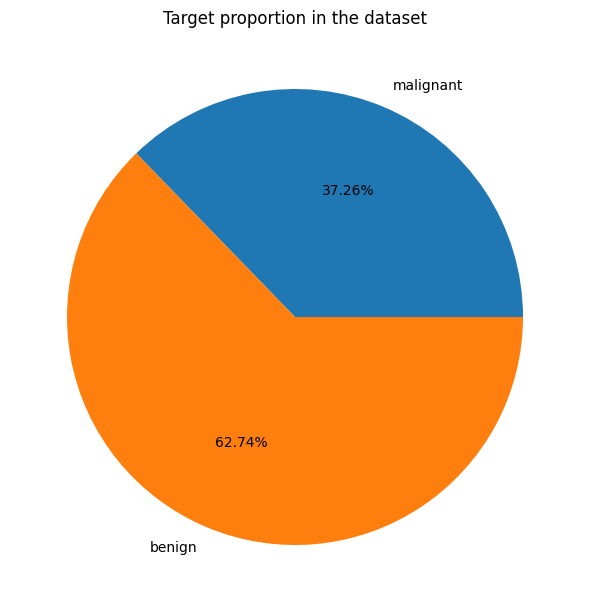

In [6]:
plt.figure(figsize=(6, 6))
labels = visualize_data.target_names
counts = np.bincount(visualize_data.target)
plt.pie(counts, labels = labels,autopct='%1.2f%%')
plt.tight_layout()
plt.title('Target proportion in the dataset')
plt.show()

Since we have 30 features, each data example lies in 30-dimensional space, making it incredibly hard to visualize. We will use a dimensionality reduction technique called PCA to project each point into 2-D space. <br>
**Note:** each $(x, y)$ pair is just a 2-D representation of each datapoint computed by PCA, which doesn't have any physical interpretation <br>
**To read more:** check out [this article](https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d/) which explains the basic theory behind the PCA algorithm

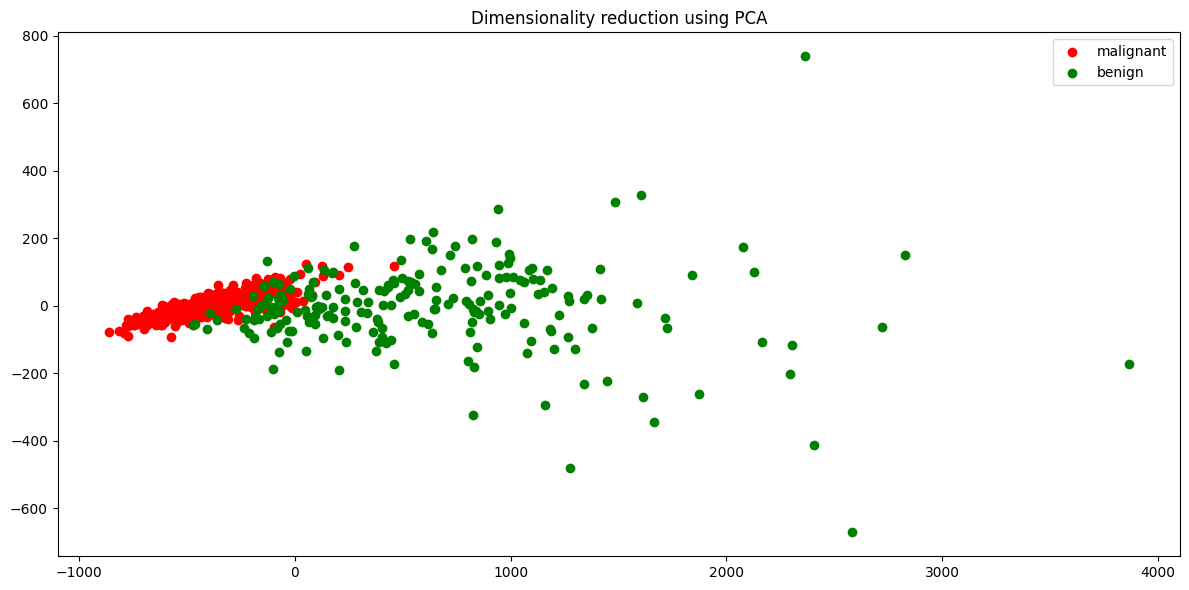

In [7]:
X_embedded = PCA(n_components=2).fit_transform(visualize_data.data)
malignant = X_embedded[visualize_data.target == 1]
benign = X_embedded[visualize_data.target == 0]
plt.figure(figsize=(12, 6))
plt.scatter(malignant[:,0], malignant[:,1], c='red', label='malignant')
plt.scatter(benign[:,0], benign[:,1], c='green', label='benign')
plt.title('Dimensionality reduction using PCA')
plt.legend()
plt.tight_layout()
plt.show()

Now let's take a look at features. We will visualize distributions of the first ten features:
- mean radius
- mean texture
- mean perimeter
- mean area
- mean smoothness
- mean compactness
- mean concavity
- mean concave points
- mean symmetry
- mean fractal dimension

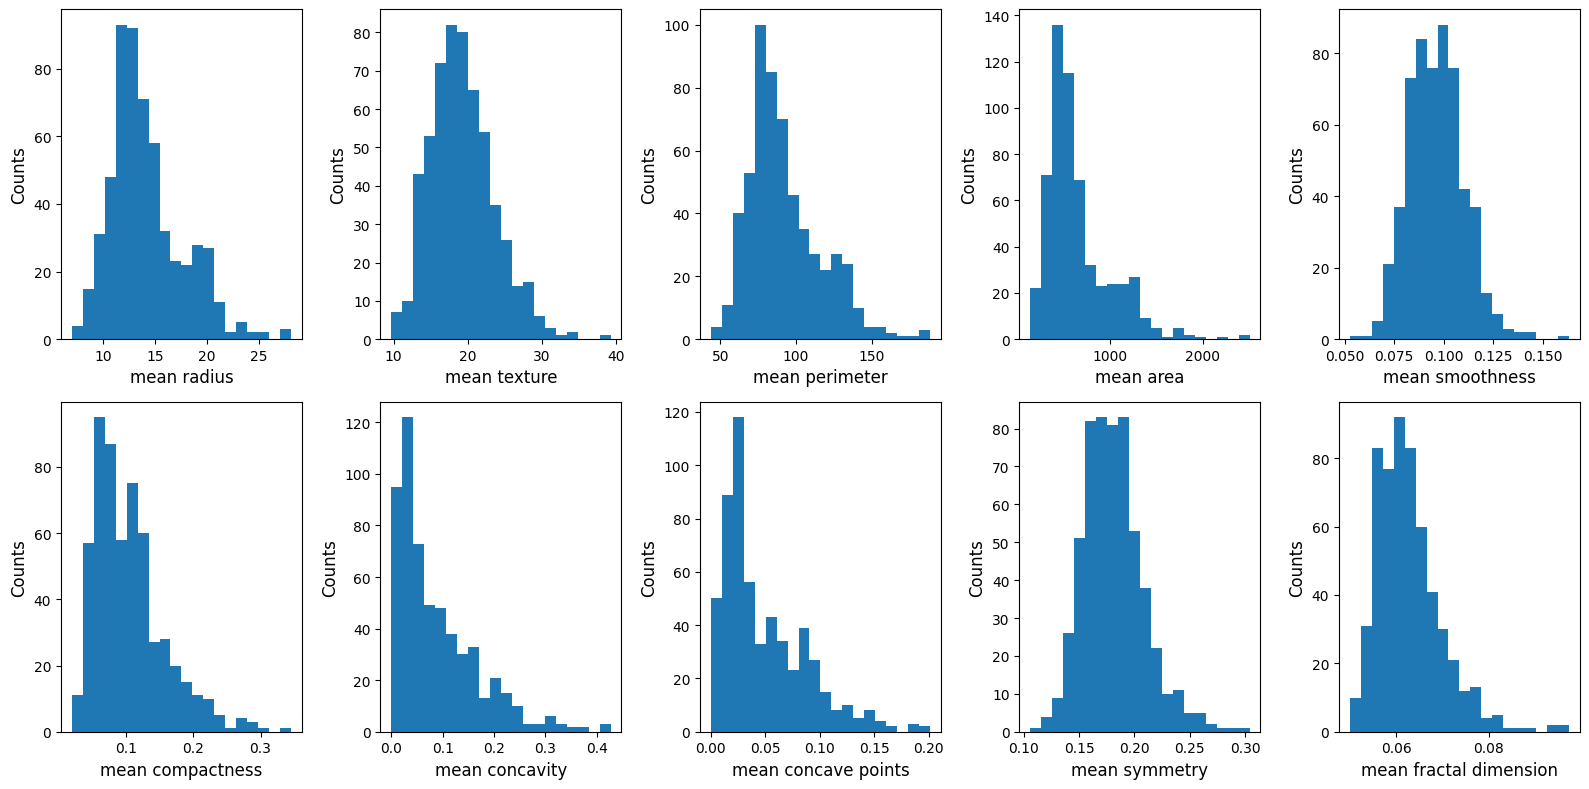

In [8]:
def plot_features(features, feature_names):
    fig, axes = plt.subplots(2, 5, figsize=(16, 8))
    for index, feature_name in enumerate(feature_names[:10]):
        # select correct axes 
        ax = axes[index // 5,index % 5]
        ax.hist(features[:, index], bins=20)
        ax.set_ylabel('Counts', size=12)
        ax.set_xlabel(feature_name, size=12)
    plt.tight_layout()
    plt.show()

plot_features(visualize_data.data, visualize_data.feature_names)

## Normalizaion

Normalization is perhaps the most common preprocessing step in machine learning. Converting the distribution of each training feature to the mean of 0 and standard deviation of 1 speeds up the training process and equalizes the importance of each feature. 

To implement data normalization, all we have to do is:

$$X_{new}= \frac{X - \mu}{\sigma}$$

where $\mu$ is the mean of $X$ across all data examples, and $\sigma$ is the standard deviation of $X$ across all data examples.

To implement the normalization step, you have to do the following:
- concatenate the inputs 
- compute the mean and std of concatenated inputs 
- use the equation above to compute the normalized values

**Note:** you can do the following with `sklearn.preprocessing.StandardScaler`, but in this lab, we will implement it ourselves to review some of the basic concepts associated with NumPy arrays.


In [19]:
# VALIDATION_FIELD[func] normalize

def normalize(X_train, X_test):
    """
    Normalizes input values of X_train and X_test

    Arguments:
    X_train -- numpy array of shape [m_train, num_features].
    X_train -- numpy array of shape [m_test, num_features].

    Return:
    X_train_normalized -- normalized train inputs
    X_test_normalized -- normalized test inputs
    """
    ### START CODE HERE ### (≈ 5 line of code)
    X_combined = np.concatenate([X_train, X_test])
    mean = X_combined.mean(axis=0)
    std = X_combined.std(axis=0)
    X_train_normalized = (X_train - mean) / std
    X_test_normalized = (X_test - mean) / std
    ### END CODE HERE ###
    return X_train_normalized, X_test_normalized

In [20]:
X_train_norm, X_test_norm = normalize(X_train, X_test)
print(X_train_norm[0:3, 0:3])
print(X_test_norm[0:3, 0:3])

[[ 0.9152949   0.8773861   0.78388933]
 [ 0.2251404  -1.01451947  0.18457191]
 [-0.6070212   1.30323939 -0.59145146]]
[[-0.92795724  0.5097095  -0.96628228]
 [ 0.23366083 -0.1209257   0.24182629]
 [ 1.75029663 -1.15181643  1.77657315]]


**Expected Output:**

<table>
    <tr>
        <td><b>X_train_norm[0:3, 0:3]</b></td>
      <td> [[ 0.9152949   0.8773861   0.78388933]<br>
 [ 0.2251404  -1.01451947  0.18457191]<br>
 [-0.6070212   1.30323939 -0.59145146]]</td>
    </tr>
    <tr>
        <td><b>X_test_norm[0:3, 0:3]</b></td>
        <td> [[-0.92795724  0.5097095  -0.96628228]<br>
 [ 0.23366083 -0.1209257   0.24182629]<br>
 [ 1.75029663 -1.15181643  1.77657315]] </td>
    </tr>

</table>

Let's visualize the effects of normalization:

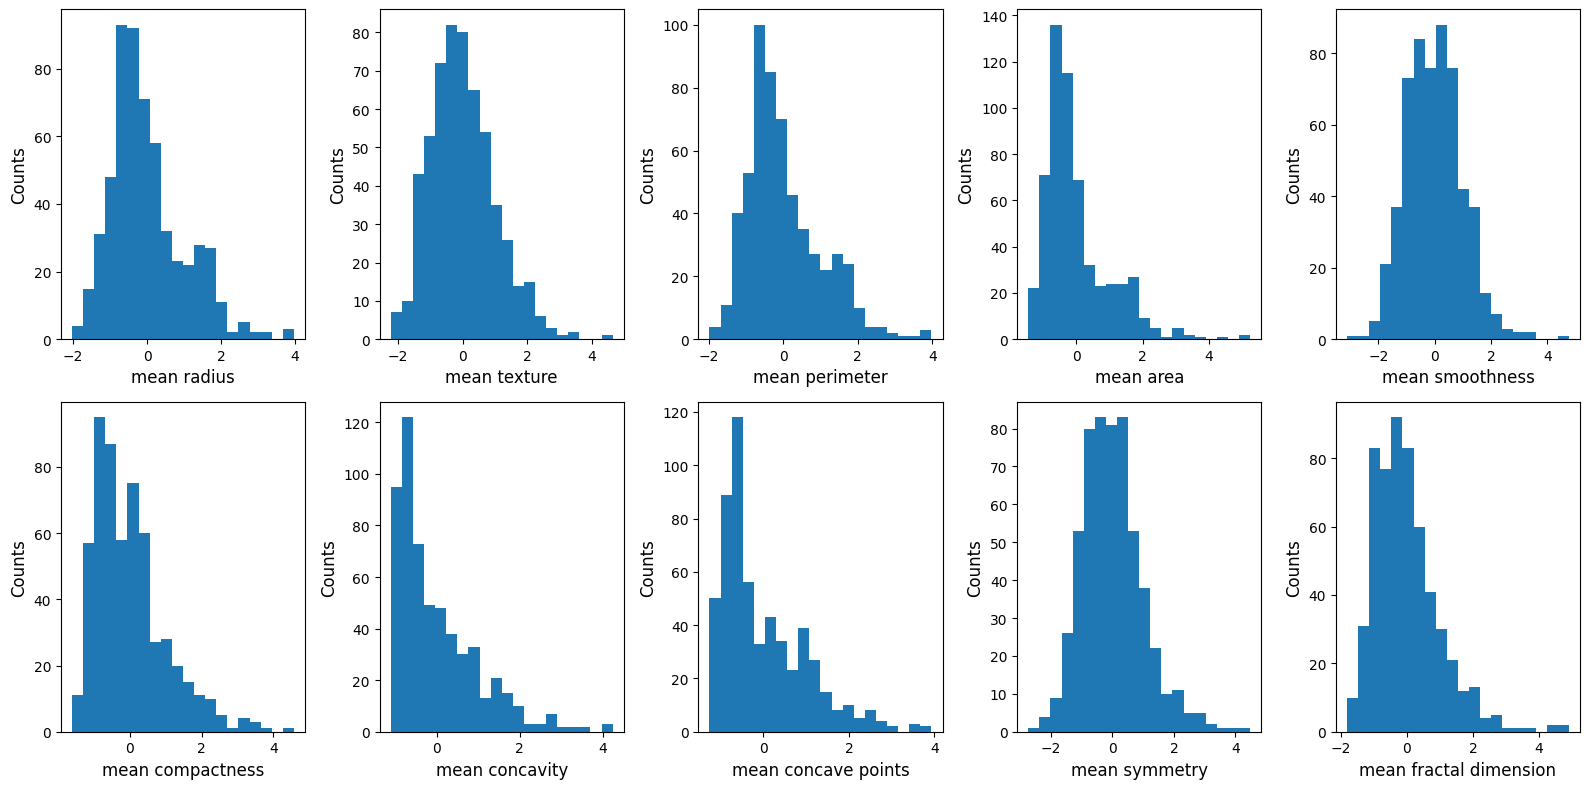

In [21]:
full_data = np.concatenate([X_train_norm, X_test_norm])
plot_features(full_data, visualize_data.feature_names)

# 3 - Model

For this task, we will implement a simple **feedforward neural network** for binary classification. The network will have two hidden layers with **64** and **32** neurons and **ReLU** activation function. The output of this neural network will be a probability of breast cancer. Therefore, the last layer will have only one neuron with a **sigmoid** activation function.

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/binary_cls_network.png">

## Implementation

To implement this model in PyTorch, we will have to do the following:
1. subclass from `nn.Module`
2. define `__init__()`
3. define `forward()`

### **nn.Module:**
`nn.Module` is a base class for all neural network modules. Subclassing from `nn.Module` will define many important methods for our model, such as `eval()`, `parameters()`, `state_dict()`, etc,  that will help us during training and evaluation. Modules can also contain other Modules, allowing to nest them in a tree structure, which is especially useful with huge neural networks that have repeating components<br>

### **\_\_init\_\_():**
In `__init__`, we have to call super of the parent class `nn.Module` to instantiate our model class as a PyTorch module. After that, we can define our layers like `nn.Linear` or `nn.Conv2d`, which will be automatically included in the model's list of parameters. If you are using custom layers with learnable parameters, you must wrap them with `nn.Parameter` to include them in the list of model parameters. Also, you can wrap your layers in `nn.Sequential` to pre-define the order of operations or define layers iteratively using `nn.ModuleList`<br>

### **forward():**
In `forward()`, we simply have to call layers defined in the `__init__` to compute the output of our neural network.


**Excercise:** Define `__init__()` and `forward()` methods for the fully conected neural network. <br>
**Directions:**
- Your neural network must have 3 sequential blocks (named `fc1`, `fc2` and `fc3`):
    - First two sequential blocks must to have linear layer followed by dropout (with 0.2 probability) and relu activation function.
    - Last sequential block has only one linear layer followed by sigmoid activation function.
    - Hidden sizes are 64 and 32 respectively
    - You **must** use `nn.Sequential`!
- In forwards simply pass your inputs through sequential blocks defined in `__init__()` 


In [26]:
# VALIDATION_FIELD[cls] NNet
 
class NNet(nn.Module):
    def __init__(self, input_dim):
        super(NNet, self).__init__()
        ### START CODE HERE ### 
        self.fc1 = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        ### END CODE HERE ###
        
    def forward(self, x):
        ### START CODE HERE ### 
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        ### END CODE HERE ### 
        return x

In [27]:
print(NNet(input_dim=Config.input_dim))

NNet(
  (fc1): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


**Expected Output:**

```
NNet(
  (fc1): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
```

# 4 - Training the model

Now let’s define accuracy function to validate our model

## Accuracy Function

In [94]:
# VALIDATION_FIELD[func] accuracy

def accuracy(net_output, target_label):
    """
    Calculates accuracy using outputs from the neural network and 
    target labels

    Arguments:
    net_output: 1-D torch tensor of raw network predictions 
    target_label: 1-D torch tensor of labels of the same shape as net_output

    Return:
    accuracy: float value of accuracy 
    """
    ### START CODE HERE ### (~3-5 lines of code)
    rounded = torch.round(net_output).long()
    correct = (rounded == target_label.long()).sum().item()
    acc = correct / len(target_label)
    ### END CODE HERE ###
    return acc

In [95]:
a = torch.tensor([0.2, 0.5, 0.3])
b = torch.tensor([0.0, 1.0, 1.0])
print('accuracy:', accuracy(a, b))

accuracy: 0.3333333333333333


**Expected Output:**

<table>
    <tr>
        <td><b>accuracy:</b></td>
      <td> 0.3333333333333333</td>
    </tr>

</table>

## Model/Optimizer/Criterion

The next step in implementing our algorithm is the train loop. Usually `train` function takes `model`, `optimizer`, `criterion`, and `dataloader` (we will simply pass `X_train`, `y_train` instead)  as parameters, so they will be defined outside of this function. Let's try to understand what each one is doing:

**model** is an instance of a neural network that we are training. Note that we pass the model to the device to make sure that all parameters are `cuda` tensors if `torch.defice('cuda')` was specified in Config.
```python
net = NNet(input_dim=Config.input_dim).to(Config.device)
```

**optimizer** is a special PyTorch class that performs parameter updates during the training. All we have to do is to pass `model.parameters()` and learning rate as parameters to optimizer. There are many optimization algorithms in the `torch.optim` package, but we will use the `Adam` optimizer for this lab.

```python
optimizer = optim.Adam(net.parameters(), lr=Config.learning_rate)
```

**criterion** is a loss function that we will use during the training. We will use `BCELoss` (Binary Cross Entropy Loss) to measure how close  our prediction is to the target label.

```python
criterion = nn.BCELoss()
```

**Note:** we also want to fixate the seed before creating our model and running the experiment. This is generally good practice, and it also allows us to validate your results!

## Training Loop

Inside of the train loop, we will have two for-loops; one that iterates over the number of epochs and another that iterates over batches of data in our dataset. We will evaluate our model for every epoch by printing the current loss and epoch accuracy. 

**Excercise:** Your task would be to implement the following:
- batching (slice X_train and y_train to have `batch_size` examples)
    - do not discard the last incomplete batch
- conversion of data to the model inputs
    - convert NumPy array to float torch tensor
    - pass inputs to the device
- forward pass through the model
    - pass the inputs through the model
    - calculate loss using criterion (*outputs and targets must have the same shape) 
- model optimization 
    - null the gradients
    - call `.backward()` to calculate the gradients w.r. to the model parameters
    - perform one step of optimization
- accuracy evaluation <br>
    - calculate batch accuracy into the variable `acc`

In [100]:
# VALIDATION_FIELD[func] train

def train(model, optimizer, criterion, X_train, y_train,
          device=Config.device,
          num_epochs=Config.epochs,
          batch_size=Config.batch_size):
    loss_values, accuracy_values = [], []
    for e in range(num_epochs):
        epoch_loss, epoch_acc = 0, 0
        num_steps = 0 
        for i in range(0, X_train.shape[0], batch_size): 
            ### START CODE HERE ### 
            # forward pass through the model (≈6 lines of code)
            x_batch = X_train[i : i + batch_size]                                   # Load batch_size of samples from X_train 
            y_batch = y_train[i : i + batch_size]                                   # Load batch_size of corresponding target values from y_train 
            x_tensor = torch.FloatTensor(x_batch).to(device)                        # Create torch.FloatTensor from x_batch and pass it to device
            y_tensor = torch.FloatTensor(y_batch).unsqueeze(1).to(device)           # Create torch.FloatTensor from y_batch and pass it to device
            out = model(x_tensor)                                                   # Pass x_batch forward through the model
            loss = criterion(out, y_tensor)                                         # Calculate the loss using criterion
            # perform optimization (≈3 lines of code)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # evaluate accuracy (1 line of code)
            acc = accuracy(out, y_tensor)
            ### END CODE HERE ###
            num_steps += 1
            epoch_loss += loss.item()
            epoch_acc += acc
        epoch_loss /= num_steps
        epoch_acc /= num_steps
        print(f'EPOCH: {e+1} \tACC: {epoch_acc:.3f}\tLOSS: {epoch_loss:.3f}')
        loss_values.append(epoch_loss)
        accuracy_values.append(epoch_acc)
    return loss_values, accuracy_values

In [101]:
set_seed(Config.seed)
net = NNet(input_dim=Config.input_dim).to(Config.device)
optimizer = optim.Adam(net.parameters(), lr=Config.learning_rate)
criterion = nn.BCELoss()
loss, acc = train(net, optimizer, criterion, X_train_norm, y_train)

EPOCH: 1 	ACC: 0.909	LOSS: 0.471
EPOCH: 2 	ACC: 0.940	LOSS: 0.188
EPOCH: 3 	ACC: 0.964	LOSS: 0.107
EPOCH: 4 	ACC: 0.966	LOSS: 0.095
EPOCH: 5 	ACC: 0.979	LOSS: 0.071
EPOCH: 6 	ACC: 0.971	LOSS: 0.074
EPOCH: 7 	ACC: 0.979	LOSS: 0.060
EPOCH: 8 	ACC: 0.984	LOSS: 0.059
EPOCH: 9 	ACC: 0.984	LOSS: 0.056
EPOCH: 10 	ACC: 0.982	LOSS: 0.049
EPOCH: 11 	ACC: 0.984	LOSS: 0.045
EPOCH: 12 	ACC: 0.987	LOSS: 0.037
EPOCH: 13 	ACC: 0.992	LOSS: 0.038
EPOCH: 14 	ACC: 0.987	LOSS: 0.041
EPOCH: 15 	ACC: 0.990	LOSS: 0.031
EPOCH: 16 	ACC: 0.990	LOSS: 0.034
EPOCH: 17 	ACC: 0.992	LOSS: 0.029
EPOCH: 18 	ACC: 0.995	LOSS: 0.028
EPOCH: 19 	ACC: 0.990	LOSS: 0.029
EPOCH: 20 	ACC: 0.995	LOSS: 0.025
EPOCH: 21 	ACC: 0.995	LOSS: 0.019
EPOCH: 22 	ACC: 0.992	LOSS: 0.023
EPOCH: 23 	ACC: 0.995	LOSS: 0.018
EPOCH: 24 	ACC: 0.995	LOSS: 0.018
EPOCH: 25 	ACC: 0.992	LOSS: 0.016
EPOCH: 26 	ACC: 0.995	LOSS: 0.017
EPOCH: 27 	ACC: 0.987	LOSS: 0.055
EPOCH: 28 	ACC: 0.995	LOSS: 0.015
EPOCH: 29 	ACC: 0.995	LOSS: 0.015
EPOCH: 30 	ACC: 0.997	L

**Expected Output:**

```
EPOCH: 1 	ACC: 0.912	LOSS: 0.476
EPOCH: 2 	ACC: 0.948	LOSS: 0.196
EPOCH: 3 	ACC: 0.969	LOSS: 0.109
EPOCH: 4 	ACC: 0.974	LOSS: 0.080
EPOCH: 5 	ACC: 0.971	LOSS: 0.075
...
```

Let's visualize the training loss and accuracy

In [ ]:
fig, ax =  plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(loss)
ax[0].set_title('Training Loss')
ax[1].plot(acc)
ax[1].set_title('Training Accuracy')
plt.tight_layout()
plt.show()

**Interpretation:** As we can see, our Neural Network quickly overfits training data, and by epoch, **30**, it has a close to perfect accuracy of **1.00**. Of course, this doesn't mean that we can correctly classify **100%** of cancer cases in the world; it just means that we learned a decision boundary for **381** training examples, which may or may not be a good decision boundary for all data. In future labs, we will learn how to use the `validation` set to prevent the algorithm from overfitting on the train data, but for now, we will simply check our final result on the `test` set that the model didn't see during the training.

# 5 - Evaluating the model

We must test our model on the subset of data that is **different** from train data. Otherwise, we might overfit the training data and fail to generalize our model to the new data examples. 

**Important:** During the evaluation, we are calling `model.eval()` to tell PyTorch that we are in the inference mode; this will turn off `dropout` layers and switch layers like `BatchNorm` to the evaluation mode (we are not using this layer in our model). Also, we wrap our code with `torch.no_grad()` to turn off any gradient calculations during a forward pass through the model.

**Excercise:** Implement function `evaluate`. The logic of the function is identical to the train function, except we don't need to calculate the backward pass and optimize parameters.

In [104]:
# VALIDATION_FIELD[func] evaluate

def evaluate(model, criterion, X_test, y_test,
             device=Config.device,
             batch_size=Config.batch_size):
    model.eval()
    with torch.no_grad():
        overall_accuracy, overall_loss = 0, 0
        for i in range(0, X_test.shape[0], batch_size): 
            ### START CODE HERE ### (≈7 lines of code)
            x_batch = X_test[i : i + batch_size]
            y_batch = y_test[i : i + batch_size]
            x_tensor = torch.FloatTensor(x_batch).to(device)             
            y_tensor = torch.FloatTensor(y_batch).unsqueeze(1).to(device)
            out = model(x_tensor)                                        
            loss = criterion(out, y_tensor)                              
            acc = accuracy(out, y_tensor)
            ### END CODE HERE ###
            overall_accuracy += acc
            overall_loss += loss.item()
        count = np.ceil(X_test.shape[0]/batch_size)
        overall_loss /= count
        overall_accuracy /= count
    return {'test loss': overall_loss, 'test accuracy': overall_accuracy}

In [105]:
results = evaluate(net, criterion, X_test_norm, y_test)
print('test accuracy:', results['test accuracy'])
print('test loss:', results['test loss'])

test accuracy: 0.9583333333333334
test loss: 0.13867969256898505


**Expected Output:**

<table>
    <tr>
        <td><b>test accuracy:</b></td>
      <td> 0.9635416666666666</td>
    </tr>
    <tr>
        <td><b>test loss:</b></td>
      <td> 0.1359550086690433</td>
    </tr>

</table>

# 6 - Next steps

Congratulations on building your first neural network! Remember to submit your assignment to `@DRU bot`. After you do so, come back and try the following:

- Change hyperparameters in Config, and see how it affects the model!
    - change `learning_rate`, `num_epochs`, and `batch_size`
- Change model architecture. 
    - experiment with a different number of layers, different sizes of hidden layers, and different regularization techniques.
- Change optimizer
    - You can tune hyperparameters of `Adam` optimizer like `beta` and `weight_decay`
    - Try new optimizers: `SGD`, `RMSProp`, `Adagrad`, etc.